<a href="https://colab.research.google.com/github/buon-viaggio/SOCAR-AI-BOOT-CAMP/blob/main/%ED%95%B4%EC%BB%A4%ED%86%A4_%EB%8B%A4%ED%95%A8%EA%BB%98%EC%B0%A8%EC%B0%BE%EC%9E%90_Clustering_PCAxKMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 인구 데이터 클러스터링
참고자료
- https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/
- https://365datascience.com/tutorials/python-tutorials/pca-k-means/
- (PCA 기법에 대한 쉬운 설명) https://kkokkilkon.tistory.com/169

In [ ]:
# 한글 폰트 설치 코드
# 실행 후 런타임 재시작 필요
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

##Import


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

In [ ]:
!pip install scikit-fda

In [ ]:
from skfda.exploratory.visualization.clustering import (ClusterMembershipLinesPlot, ClusterMembershipPlot,ClusterPlot)
from skfda.ml.clustering import FuzzyCMeans, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


## 데이터셋 로드


In [ ]:
import gspread
import pandas as pd
from google.colab import auth
auth.authenticate_user()
from google.auth import default

creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
worksheet = gc.open('clustering_dataset-main').sheet1
rows = worksheet.get_all_values()
data = pd.DataFrame.from_records(rows)
columns=data.iloc[0]
data1 = data.rename(columns=columns)
data2 = data1.drop(['위치'], axis=1)
data3 = data2.drop(['총인구'], axis=1)
data4 = data3.drop(['운전자'], axis=1)
dataset = data4.drop(data4.index[0])
dataset.head(10)

,평균나이,세대원1명,세대원2명,세대원3명이상,1인가구,2인가구,3인이상가구,외국인인구,비혈연6인이상가구인구,집단가구인구,...,면허소지자_15~19세,면허소지자_20대,면허소지자_30대,면허소지자_40대,면허소지자_50대,면허소지자_60대,면허소지자_70대,면허소지자_80대이상,등록된차량수,주차장보급율
1,46.8,758.0,646.0,1312.0,550.0,654.0,1120.0,5.0,6.0,0.0,...,2107.0,47107.0,58045.0,88650.0,100650.0,111145.0,38304.0,6039.0,3599.0,167.9
2,40.9,1648.0,2199.0,5932.0,1058.0,2081.0,4288.0,59.0,0.0,123.0,...,11743.0,213886.0,273458.0,421950.0,425700.0,304017.0,79423.0,9961.0,9948.0,167.9
3,42.1,3541.0,2275.0,4221.0,2280.0,2095.0,3423.0,165.0,46.0,169.0,...,8159.0,211647.0,323995.0,377100.0,379100.0,285034.0,73281.0,9864.0,8563.0,167.9
4,42.7,9526.0,2381.0,2088.0,7121.0,2983.0,2173.0,716.0,76.0,29.0,...,3544.0,295505.0,506792.0,359600.0,266250.0,210455.0,74674.0,11938.0,10529.0,167.9
5,43.0,6474.0,2093.0,2846.0,4618.0,2608.0,2853.0,318.0,31.0,0.0,...,5091.0,229555.0,396183.0,362250.0,283400.0,204997.0,82892.0,11938.0,10295.0,167.9
6,38.6,602.0,1058.0,5596.0,350.0,1147.0,5489.0,38.0,0.0,0.0,...,19140.0,160966.0,134610.0,584600.0,387450.0,185869.0,59461.0,8902.0,14360.0,167.9
7,41.4,2622.0,2493.0,7793.0,1807.0,2567.0,7598.0,169.0,25.0,0.0,...,24175.0,312009.0,294281.0,701000.0,652800.0,408013.0,119661.0,14682.0,15069.0,167.9
8,40.7,5594.0,1689.0,2880.0,4269.0,2117.0,2851.0,318.0,56.0,0.0,...,11485.0,223407.0,297414.0,392850.0,314100.0,147033.0,58551.0,7703.0,10306.0,167.9
9,41.5,2738.0,1663.0,4138.0,1872.0,1871.0,4039.0,141.0,34.0,52.0,...,8026.0,190466.0,283501.0,376850.0,340800.0,242625.0,68390.0,11992.0,8974.0,167.9
10,41.4,2221.0,2455.0,6972.0,1408.0,2676.0,6689.0,171.0,19.0,0.0,...,17272.0,257418.0,311050.0,632550.0,541600.0,337636.0,118751.0,19555.0,13615.0,167.9


In [ ]:
print(dataset.dtypes)

평균나이            object
세대원1명           object
세대원2명           object
세대원3명이상         object
1인가구            object
2인가구            object
3인이상가구          object
외국인인구           object
비혈연6인이상가구인구     object
집단가구인구          object
인구_15세미만        object
15~19세          object
20대             object
30대             object
40대             object
50대             object
60대             object
면허소지자_15~19세    object
면허소지자_20대       object
면허소지자_30대       object
면허소지자_40대       object
면허소지자_50대       object
면허소지자_60대       object
면허소지자_70대       object
면허소지자_80대이상     object
등록된차량수          object
주차장보급율          object
dtype: object


In [ ]:
dataset_numeric = dataset.astype(float)
print (dataset_numeric.dtypes)

평균나이            float64
세대원1명           float64
세대원2명           float64
세대원3명이상         float64
1인가구            float64
2인가구            float64
3인이상가구          float64
외국인인구           float64
비혈연6인이상가구인구     float64
집단가구인구          float64
인구_15세미만        float64
15~19세          float64
20대             float64
30대             float64
40대             float64
50대             float64
60대             float64
면허소지자_15~19세    float64
면허소지자_20대       float64
면허소지자_30대       float64
면허소지자_40대       float64
면허소지자_50대       float64
면허소지자_60대       float64
면허소지자_70대       float64
면허소지자_80대이상     float64
등록된차량수          float64
주차장보급율          float64
dtype: object


## Visualize Raw Data

Text(0.5, 1.0, 'RawData 시각화')

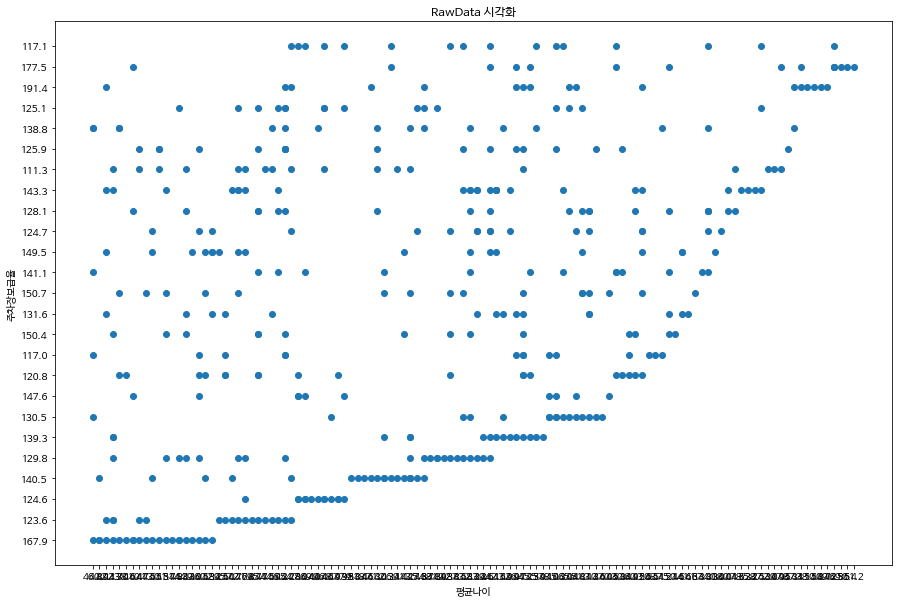

In [ ]:
plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize = (15,10))
plt.scatter(dataset['평균나이'],dataset['주차장보급율'])
plt.xlabel('평균나이')
plt.ylabel('주차장보급율')
plt.title('RawData 시각화')

Text(0.5, 1.0, 'RawData 시각화')

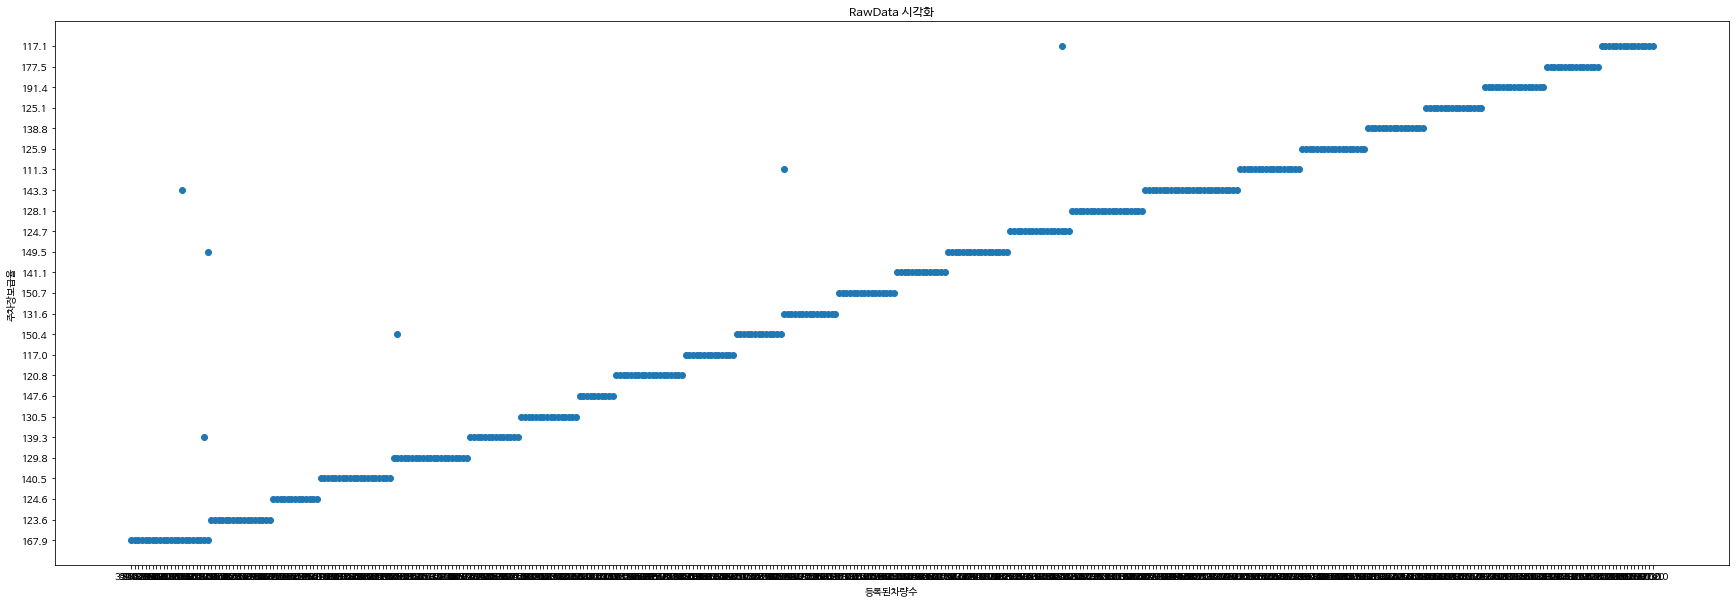

In [ ]:
plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize = (30,10))
plt.scatter(dataset['등록된차량수'],dataset['주차장보급율'])
plt.xlabel('등록된차량수')
plt.ylabel('주차장보급율')
plt.title('RawData 시각화')

Text(0.5, 1.0, 'RawData 시각화')

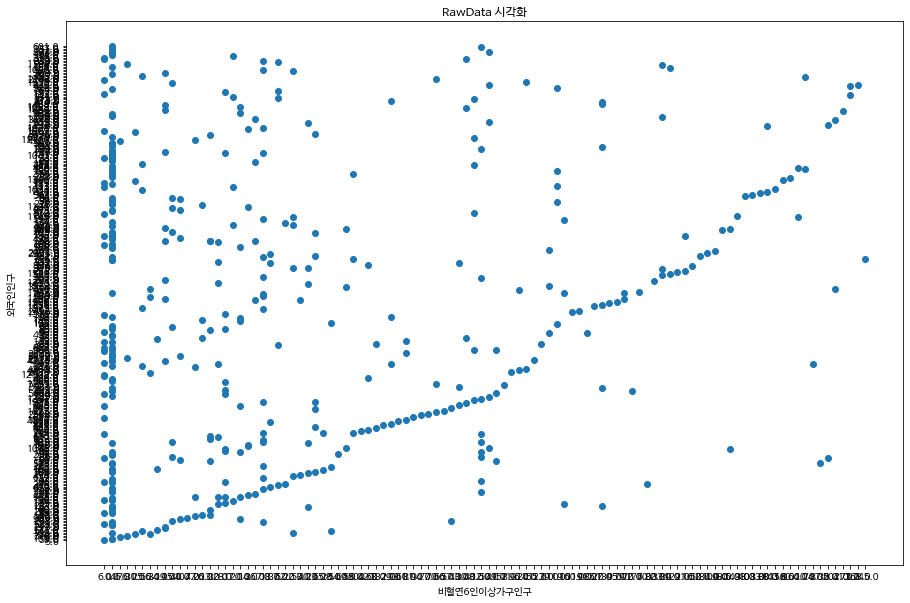

In [ ]:
plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize = (15,10))
plt.scatter(dataset['비혈연6인이상가구인구'],dataset['외국인인구'])
plt.xlabel('비혈연6인이상가구인구')
plt.ylabel('외국인인구')
plt.title('RawData 시각화')

Text(0.5, 1.0, 'RawData 시각화')

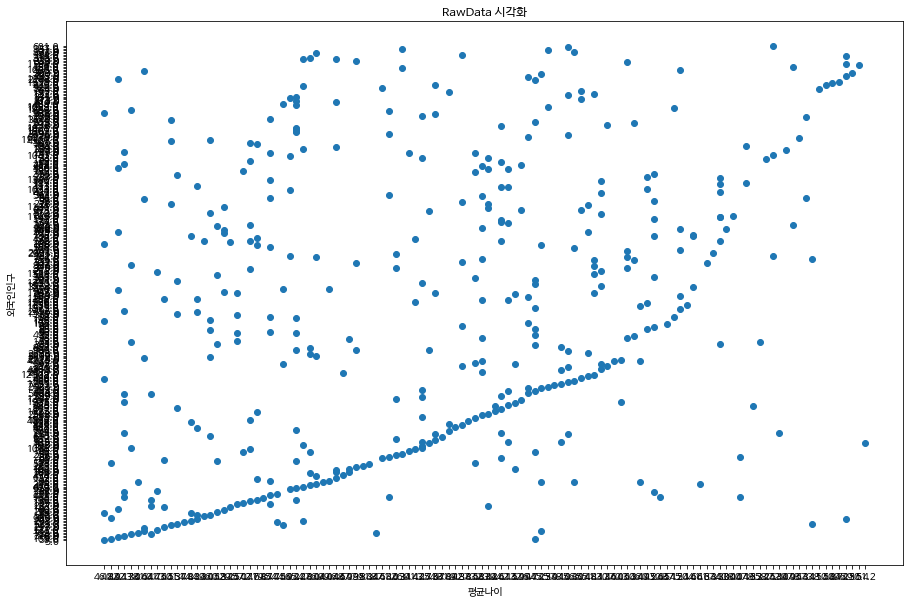

In [ ]:
plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize = (15,10))
plt.scatter(dataset['평균나이'],dataset['외국인인구'])
plt.xlabel('평균나이')
plt.ylabel('외국인인구')
plt.title('RawData 시각화')

Text(0.5, 1.0, 'RawData 시각화')

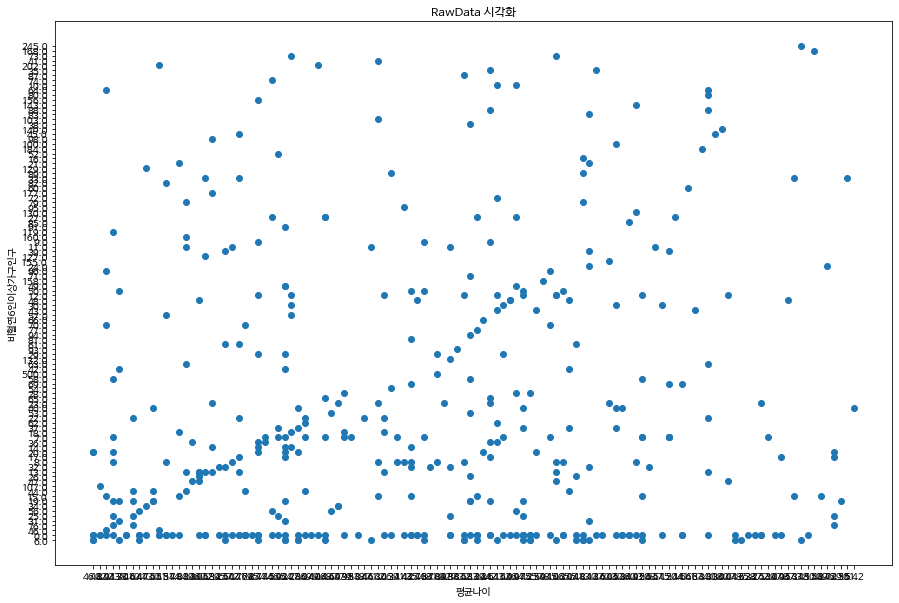

In [ ]:
plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize = (15,10))
plt.scatter(dataset['평균나이'],dataset['비혈연6인이상가구인구'])
plt.xlabel('평균나이')
plt.ylabel('비혈연6인이상가구인구')
plt.title('RawData 시각화')

Text(0.5, 1.0, 'RawData 시각화')

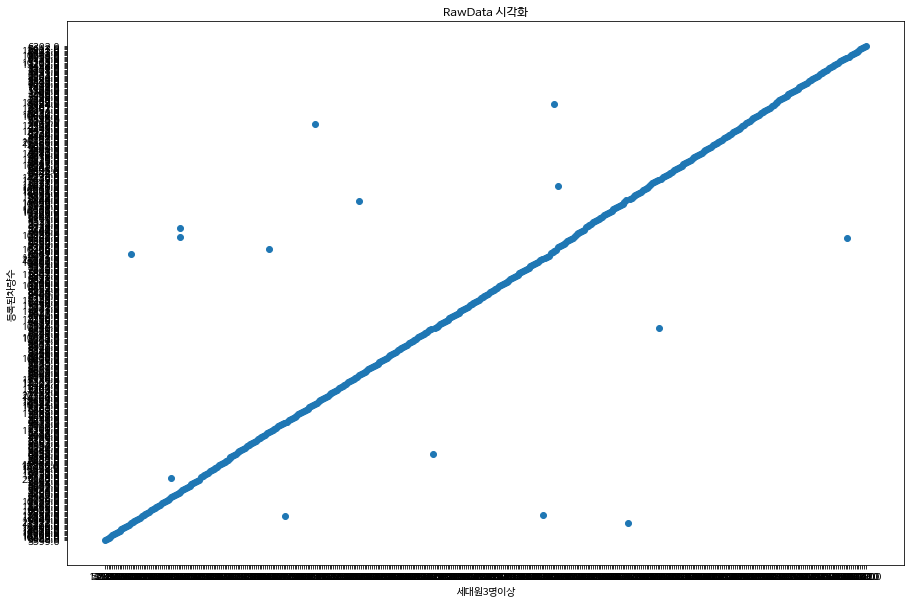

In [ ]:
plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize = (15,10))
plt.scatter(dataset['세대원3명이상'],dataset['등록된차량수'])
plt.xlabel('세대원3명이상')
plt.ylabel('등록된차량수')
plt.title('RawData 시각화')

Text(0.5, 1.0, 'RawData 시각화')

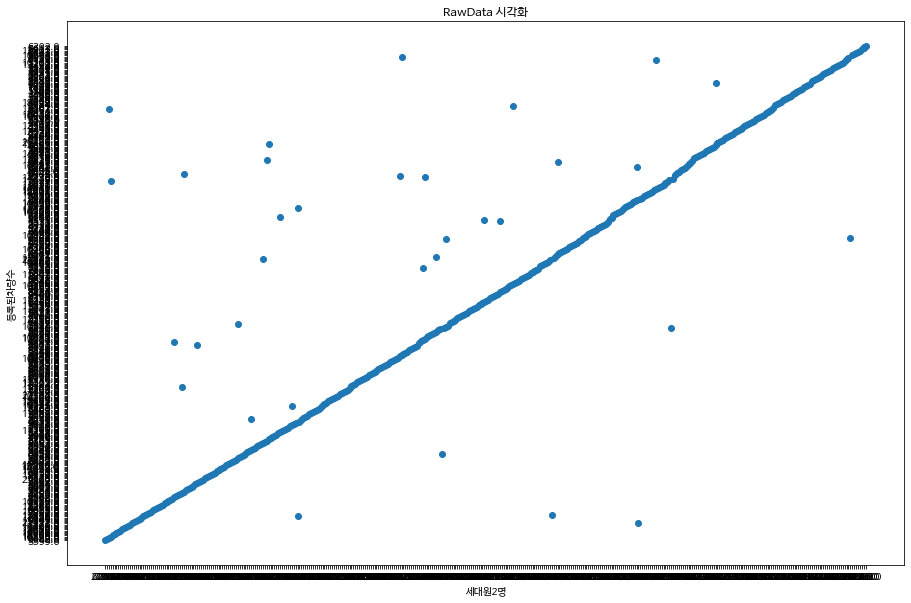

In [ ]:
plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize = (15,10))
plt.scatter(dataset['세대원2명'],dataset['등록된차량수'])
plt.xlabel('세대원2명')
plt.ylabel('등록된차량수')
plt.title('RawData 시각화')

Text(0.5, 1.0, 'RawData 시각화')

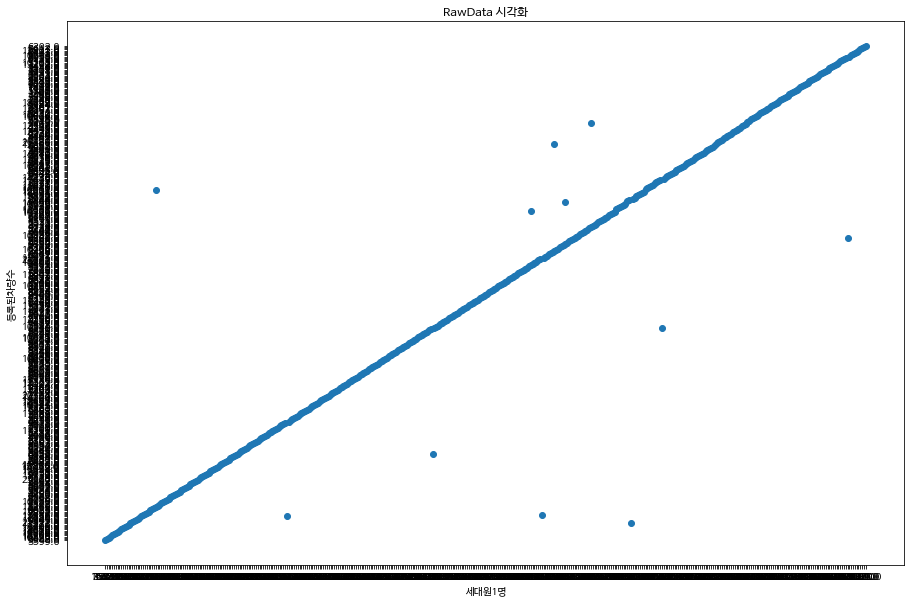

In [ ]:
plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize = (15,10))
plt.scatter(dataset['세대원1명'],dataset['등록된차량수'])
plt.xlabel('세대원1명')
plt.ylabel('등록된차량수')
plt.title('RawData 시각화')

Text(0.5, 1.0, 'RawData 시각화')

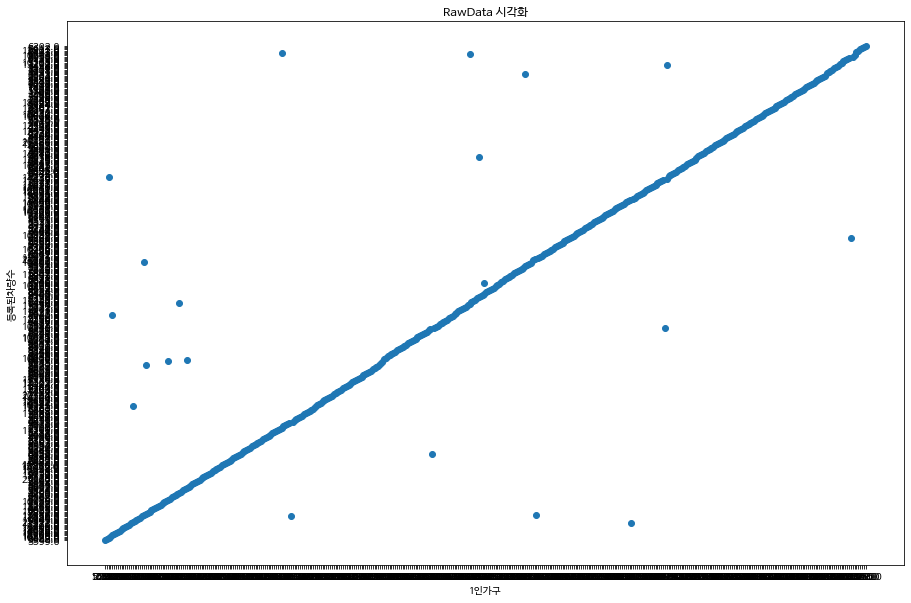

In [ ]:
plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize = (15,10))
plt.scatter(dataset['1인가구'],dataset['등록된차량수'])
plt.xlabel('1인가구')
plt.ylabel('등록된차량수')
plt.title('RawData 시각화')

Text(0.5, 1.0, 'RawData 시각화')

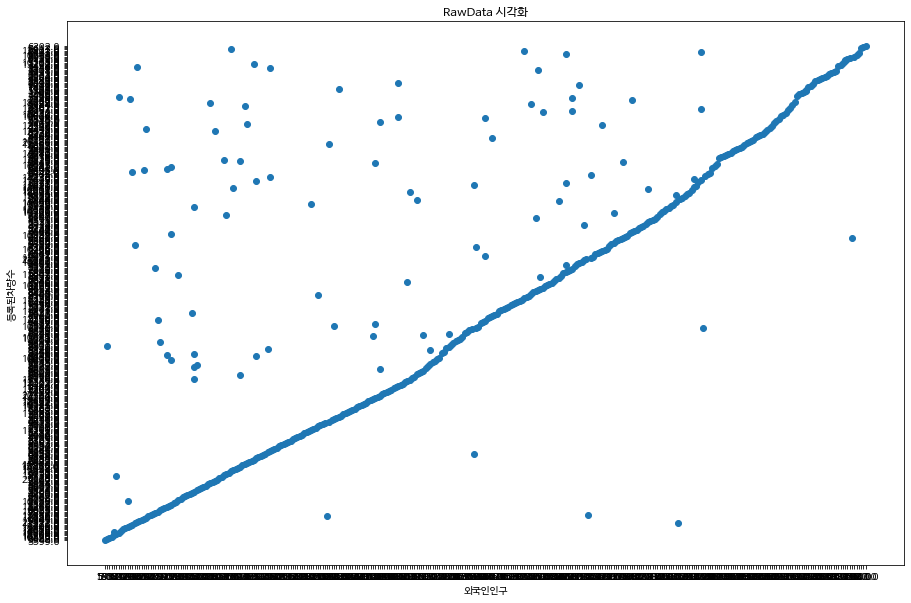

In [ ]:
plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize = (15,10))
plt.scatter(dataset['외국인인구'],dataset['등록된차량수'])
plt.xlabel('외국인인구')
plt.ylabel('등록된차량수')
plt.title('RawData 시각화')

Text(0.5, 1.0, 'RawData 시각화')

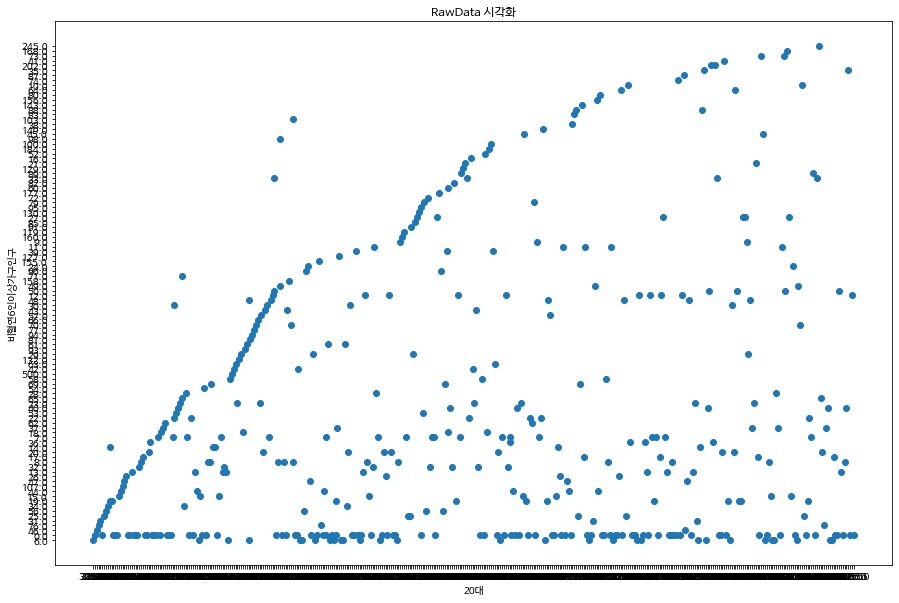

In [ ]:
plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize = (15,10))
plt.scatter(dataset['20대'],dataset['비혈연6인이상가구인구'])
plt.xlabel('20대')
plt.ylabel('비혈연6인이상가구인구')
plt.title('RawData 시각화')

Text(0.5, 1.0, 'RawData 시각화')

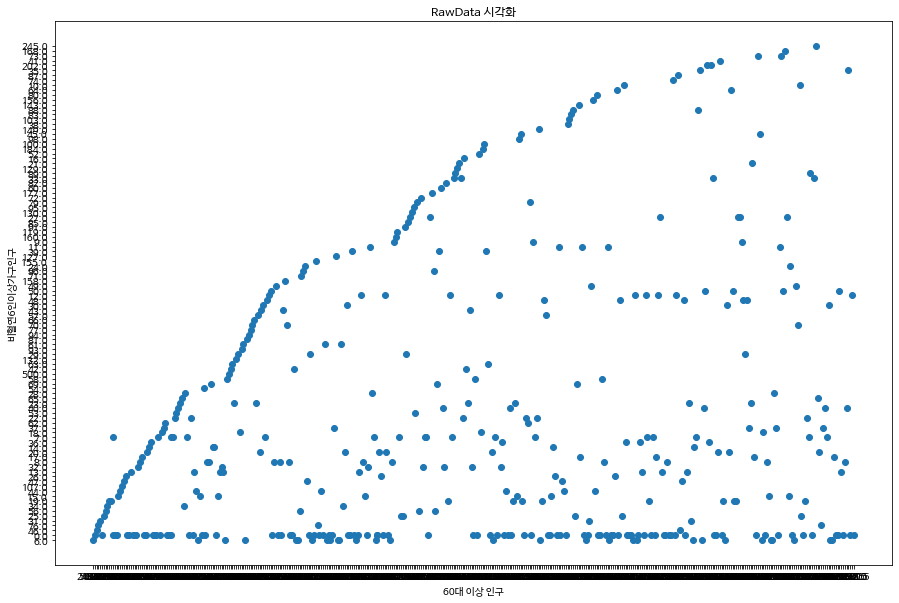

In [ ]:
plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize = (15,10))
plt.scatter(dataset['60대'],dataset['비혈연6인이상가구인구'])
plt.xlabel('60대 이상 인구')
plt.ylabel('비혈연6인이상가구인구')
plt.title('RawData 시각화')

## Standardizaiton

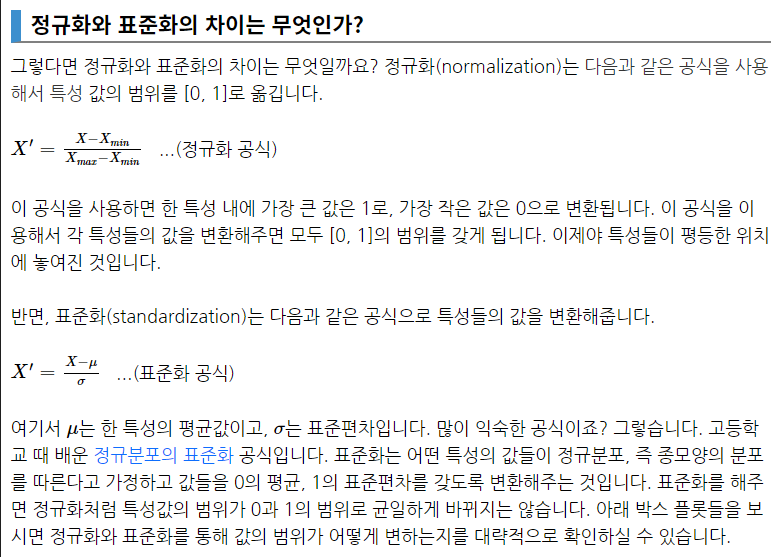

In [ ]:
scaler = StandardScaler()
dataset_stand_np = scaler.fit_transform(dataset)

In [ ]:
dataset_stand_np.view(dtype=np.float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


array([[ 0.83692006, -1.38226679, -1.79730766, ..., -1.49208063,
        -1.05859336,  1.58088817],
       [-1.0340712 , -1.0592889 , -0.12938889, ..., -0.9216142 ,
         0.67654392,  1.58088817],
       [-0.6535306 , -0.37232582, -0.04776504, ..., -0.93572313,
         0.29803311,  1.58088817],
       ...,
       [ 0.61493804, -0.50006539,  0.0821887 , ...,  0.41728013,
        -0.15180717, -1.10830221],
       [ 0.36124431, -0.34728596,  0.0821887 , ..., -0.39042005,
        -0.50818125, -1.10830221],
       [ 1.02719035,  1.02047096,  0.87050318, ...,  0.68127722,
        -0.34721167, -1.10830221]])

In [ ]:
data_stand_df = pd.DataFrame(dataset_stand_np)
dataset_stand_df = data_stand_df.rename(columns=columns)
print(dataset_stand_df)

           위치      평균나이     세대원1명     세대원2명   세대원3명이상      1인가구      2인가구  \
0    0.836920 -1.382267 -1.797308 -1.294330 -1.294033 -1.869944 -1.485559   
1   -1.034071 -1.059289 -0.129389  1.305323 -1.053234 -0.374566  0.357474   
2   -0.653531 -0.372326 -0.047765  0.342551 -0.473991 -0.359895 -0.145753   
3   -0.463260  1.799610  0.066079 -0.857678  1.820703  0.570655 -0.872960   
4   -0.368125  0.692050 -0.243233 -0.431155  0.634250  0.177686 -0.477359   
..        ...       ...       ...       ...       ...       ...       ...   
419 -0.272990  1.112284  0.150925 -0.802534  0.961792  0.217507 -0.792095   
420 -0.019296 -0.232248  1.529938  1.970430 -0.404785  1.377551  2.206907   
421  0.614938 -0.500065  0.082189 -0.112669 -0.477309  0.114811 -0.023582   
422  0.361244 -0.347286  0.082189 -0.294982 -0.439388 -0.032945 -0.184149   
423  1.027190  1.020471  0.870503 -0.264597  1.030998  0.856737 -0.117828   

       3인이상가구     외국인인구  비혈연6인이상가구인구  ...       50대       60대       운전자  \


In [ ]:
#csv로 저장
with open('/content/drive/MyDrive/다함께차찾자/dataset_standard.csv', 'w') as f:
  dataset_stand_df.to_csv(f)

## PCA 적용

In [ ]:
pca = PCA()
pca.fit(dataset_stand_np)

PCA()

In [ ]:
# explained_variance_ratio 구하기
pca.explained_variance_ratio_

# 결과값의 의미 
# 원 데이터셋 분산의 57.89%가 첫 번째 주성분 축에 놓여있고, 15.38%가 두번째 주성분 축에 놓여있다.

array([5.78923425e-01, 1.54380801e-01, 8.53697696e-02, 4.10487393e-02,
       3.39266098e-02, 3.10097567e-02, 2.24469694e-02, 1.48535351e-02,
       1.31775781e-02, 8.61343552e-03, 5.29806385e-03, 3.54323488e-03,
       2.66623050e-03, 1.64001675e-03, 9.33839365e-04, 7.93523531e-04,
       6.27390590e-04, 2.81426753e-04, 2.24249117e-04, 1.46264979e-04,
       9.51405199e-05, 8.91587446e-11, 1.12303651e-12, 1.26216460e-13,
       7.08090695e-14, 2.99550343e-33, 2.99550343e-33])

Text(0, 0.5, 'Explained Variance 누적값')

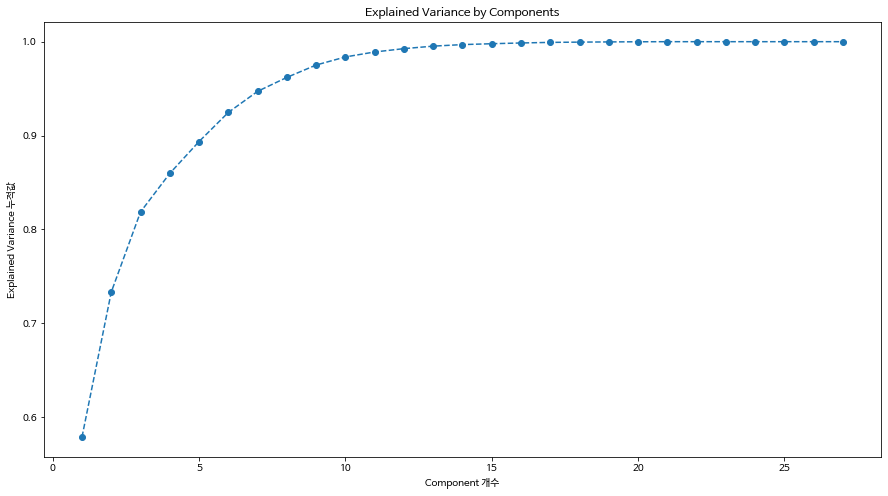

In [ ]:
plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize=(15,8))
plt.plot(range(1,28),pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Component 개수')
plt.ylabel('Explained Variance 누적값')

In [ ]:
# 차원 수 선택하기
# 95% 정도면 원형 데이터를 보존하고 있다고 판단할 수 있음. (참고 https://ratsgo.github.io/machine%20learning/2017/04/24/PCA/)
# 80%로 권장하기도 함(참고 https://365datascience.com/tutorials/python-tutorials/pca-k-means/)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d1 = np.argmax(cumsum >= 0.95) + 1
d2 = np.argmax(cumsum >= 0.90) + 1
d3 = np.argmax(cumsum >= 0.80) + 1
print('95%의 경우, 선택할 차원 수 :', d1)
print('90%의 경우, 선택할 차원 수 :', d2)
print('80%의 경우, 선택할 차원 수 :', d3)
# 3차원인 80% 선택

95%의 경우, 선택할 차원 수 : 8
90%의 경우, 선택할 차원 수 : 6
80%의 경우, 선택할 차원 수 : 3


In [ ]:
# 선택한 차원수로 PCA 수행
pca = PCA(n_components = 3)

In [ ]:
# Fit the model the our data with n_components(= 3)
pca.fit(dataset_stand_np)

PCA(n_components=3)

In [ ]:
# dataset 변수들에 component score 결과값 계산
pca.transform(dataset_stand_np)

array([[-7.21557092, -1.31163293, -0.1657585 ],
       [ 0.73471036, -2.71698698,  1.80919263],
       [-0.22252709, -0.78557711,  1.46480473],
       ...,
       [-0.39945576, -0.9742302 , -1.40484695],
       [-1.04996662, -0.31657072, -1.04464822],
       [ 1.53234514,  1.258844  , -2.49752013]])

In [ ]:
score_pca = pca.transform(dataset_stand_np)

## 클러스터링에 PCA 활용하기
- Within Cluster Sum of Squares(WCSS) 계산 : 군집수별 군집 내 군집과 개체 간 거리 제곱합의 총합
- Elbow method를 활용해 클러스터 숫자 선정 : WCSS의 그래프가 팔꿈치 모양으로 꺾이는 지점의 K를 최적 군집의 개수로 선택하는 방법

In [ ]:
# 1~20개의 클러스터수에 대해 KMeans 테스트
wcss = []
for i in range(1,21):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(score_pca)
    wcss.append(kmeans_pca.inertia_)

Text(0, 0.5, 'WCSS')

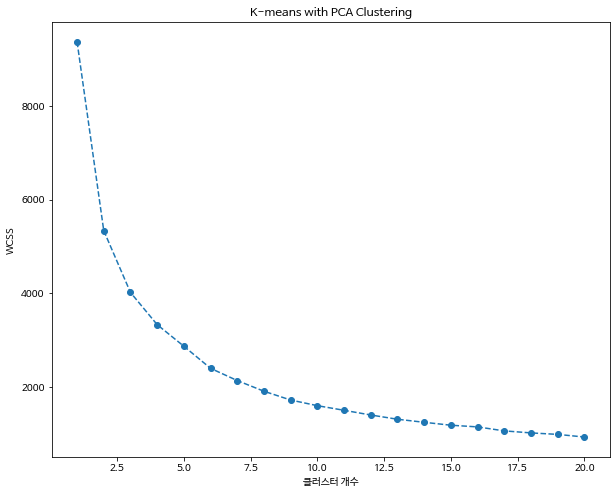

In [ ]:
# 결과물 시각화
plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize=(10,8))
plt.plot(range(1,21), wcss, marker='o', linestyle='--')
plt.title('K-means with PCA Clustering')
plt.xlabel('클러스터 개수')
plt.ylabel('WCSS')

In [ ]:
# Elbow method를 이용한 클러스터링 갯수 선정방법
# 그래프에서 급격한 감소 후 완만한 감소 추세로 바뀌는 지점
# 위 그래프에서는 애매하지만 4 혹은 6으로 보임

In [ ]:
# 선정한 클러스터 값 K-means에 적용하기
kmeans_pca = KMeans(n_clusters=4, init='k-means++', random_state=42)

In [ ]:
# fit our data with k-means pca model
kmeans_pca.fit(score_pca)

KMeans(n_clusters=4, random_state=42)

## PCA와 K-Means 클러스터링 결과 분석하기

In [ ]:
# 새로운 데이터프레임 제작 - 기존 데이터+ PCA score + 배정된 클러스터
df_pca_kmeans = pd.concat([dataset.reset_index(drop=True), pd.DataFrame(score_pca)], axis=1)
df_pca_kmeans.columns.values[-3:] = ['Component 1', 'Component 2','Component 3']
# K-Means 라벨값 추가
df_pca_kmeans['K-Means PCA 결과'] = kmeans_pca.labels_

In [ ]:
df_pca_kmeans.head(10)

,평균나이,세대원1명,세대원2명,세대원3명이상,1인가구,2인가구,3인이상가구,외국인인구,비혈연6인이상가구인구,집단가구인구,...,면허소지자_50대,면허소지자_60대,면허소지자_70대,면허소지자_80대이상,등록된차량수,주차장보급율,Component 1,Component 2,Component 3,K-Means PCA 결과
0,46.8,758.0,646.0,1312.0,550.0,654.0,1120.0,5.0,6.0,0.0,...,100650.0,111145.0,38304.0,6039.0,3599.0,167.9,-7.215571,-1.311633,-0.165758,0
1,40.9,1648.0,2199.0,5932.0,1058.0,2081.0,4288.0,59.0,0.0,123.0,...,425700.0,304017.0,79423.0,9961.0,9948.0,167.9,0.734710,-2.716987,1.809193,2
2,42.1,3541.0,2275.0,4221.0,2280.0,2095.0,3423.0,165.0,46.0,169.0,...,379100.0,285034.0,73281.0,9864.0,8563.0,167.9,-0.222527,-0.785577,1.464805,2
3,42.7,9526.0,2381.0,2088.0,7121.0,2983.0,2173.0,716.0,76.0,29.0,...,266250.0,210455.0,74674.0,11938.0,10529.0,167.9,-0.220542,3.525887,1.584430,3
4,43.0,6474.0,2093.0,2846.0,4618.0,2608.0,2853.0,318.0,31.0,0.0,...,283400.0,204997.0,82892.0,11938.0,10295.0,167.9,-0.707362,1.091263,1.195083,2
5,38.6,602.0,1058.0,5596.0,350.0,1147.0,5489.0,38.0,0.0,0.0,...,387450.0,185869.0,59461.0,8902.0,14360.0,167.9,0.596721,-5.276062,4.134752,2
6,41.4,2622.0,2493.0,7793.0,1807.0,2567.0,7598.0,169.0,25.0,0.0,...,652800.0,408013.0,119661.0,14682.0,15069.0,167.9,6.186175,-4.590802,2.821757,1
7,40.7,5594.0,1689.0,2880.0,4269.0,2117.0,2851.0,318.0,56.0,0.0,...,314100.0,147033.0,58551.0,7703.0,10306.0,167.9,-0.953510,-0.098272,2.826091,2
8,41.5,2738.0,1663.0,4138.0,1872.0,1871.0,4039.0,141.0,34.0,52.0,...,340800.0,242625.0,68390.0,11992.0,8974.0,167.9,-0.793756,-1.445842,1.689536,2
9,41.4,2221.0,2455.0,6972.0,1408.0,2676.0,6689.0,171.0,19.0,0.0,...,541600.0,337636.0,118751.0,19555.0,13615.0,167.9,4.428178,-3.815289,2.028275,1


In [ ]:
df_pca_kmeans['Segment'] = df_pca_kmeans['K-Means PCA 결과'].map({0:'First', 1:'Second', 2:'Third', 3:'Fourth'})

In [ ]:
df_pca_kmeans.head(10)

,평균나이,세대원1명,세대원2명,세대원3명이상,1인가구,2인가구,3인이상가구,외국인인구,비혈연6인이상가구인구,집단가구인구,...,면허소지자_60대,면허소지자_70대,면허소지자_80대이상,등록된차량수,주차장보급율,Component 1,Component 2,Component 3,K-Means PCA 결과,Segment
0,46.8,758.0,646.0,1312.0,550.0,654.0,1120.0,5.0,6.0,0.0,...,111145.0,38304.0,6039.0,3599.0,167.9,-7.215571,-1.311633,-0.165758,0,First
1,40.9,1648.0,2199.0,5932.0,1058.0,2081.0,4288.0,59.0,0.0,123.0,...,304017.0,79423.0,9961.0,9948.0,167.9,0.734710,-2.716987,1.809193,2,Third
2,42.1,3541.0,2275.0,4221.0,2280.0,2095.0,3423.0,165.0,46.0,169.0,...,285034.0,73281.0,9864.0,8563.0,167.9,-0.222527,-0.785577,1.464805,2,Third
3,42.7,9526.0,2381.0,2088.0,7121.0,2983.0,2173.0,716.0,76.0,29.0,...,210455.0,74674.0,11938.0,10529.0,167.9,-0.220542,3.525887,1.584430,3,Fourth
4,43.0,6474.0,2093.0,2846.0,4618.0,2608.0,2853.0,318.0,31.0,0.0,...,204997.0,82892.0,11938.0,10295.0,167.9,-0.707362,1.091263,1.195083,2,Third
5,38.6,602.0,1058.0,5596.0,350.0,1147.0,5489.0,38.0,0.0,0.0,...,185869.0,59461.0,8902.0,14360.0,167.9,0.596721,-5.276062,4.134752,2,Third
6,41.4,2622.0,2493.0,7793.0,1807.0,2567.0,7598.0,169.0,25.0,0.0,...,408013.0,119661.0,14682.0,15069.0,167.9,6.186175,-4.590802,2.821757,1,Second
7,40.7,5594.0,1689.0,2880.0,4269.0,2117.0,2851.0,318.0,56.0,0.0,...,147033.0,58551.0,7703.0,10306.0,167.9,-0.953510,-0.098272,2.826091,2,Third
8,41.5,2738.0,1663.0,4138.0,1872.0,1871.0,4039.0,141.0,34.0,52.0,...,242625.0,68390.0,11992.0,8974.0,167.9,-0.793756,-1.445842,1.689536,2,Third
9,41.4,2221.0,2455.0,6972.0,1408.0,2676.0,6689.0,171.0,19.0,0.0,...,337636.0,118751.0,19555.0,13615.0,167.9,4.428178,-3.815289,2.028275,1,Second


## 결과물 시각화

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


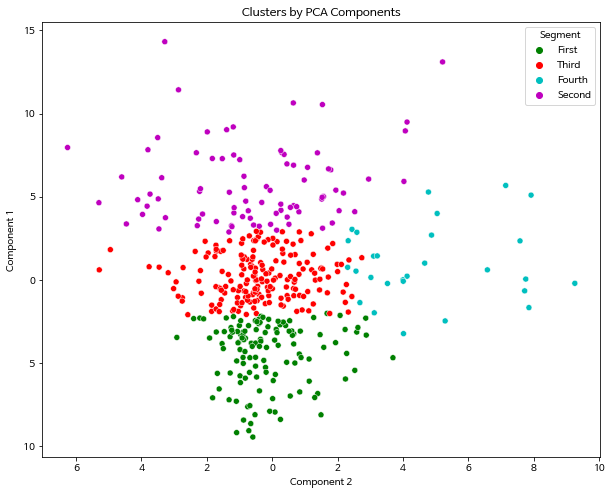

In [ ]:
x_axis = df_pca_kmeans['Component 2']
y_axis = df_pca_kmeans['Component 1']
plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis, y_axis, hue=df_pca_kmeans['Segment'], palette=['g', 'r', 'c', 'm'])
#sns.scatterplot(x_axis, y_axis, hue=df_pca_kmeans['Segment'])
plt.title('Clusters by PCA Components')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


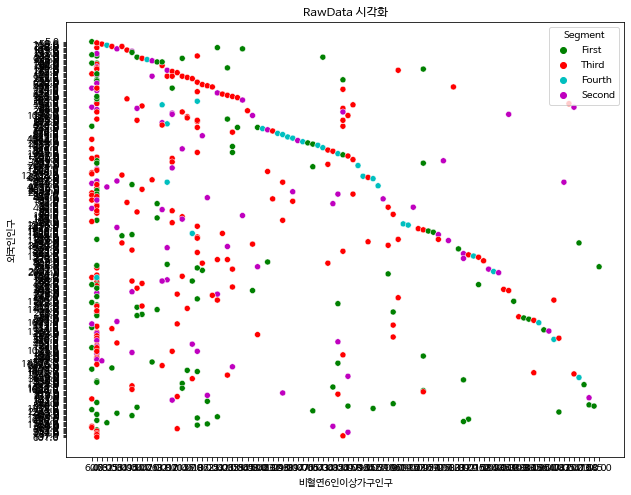

In [ ]:
# PCA 수행 전 클러스터링 결과 비교 시각화
plt.rc('font', family='NanumBarunGothic') 
x_axis = df_pca_kmeans['비혈연6인이상가구인구']
y_axis = df_pca_kmeans['외국인인구']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis, y_axis, hue=df_pca_kmeans['Segment'], palette=['g', 'r', 'c', 'm'])
plt.title('RawData 시각화')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


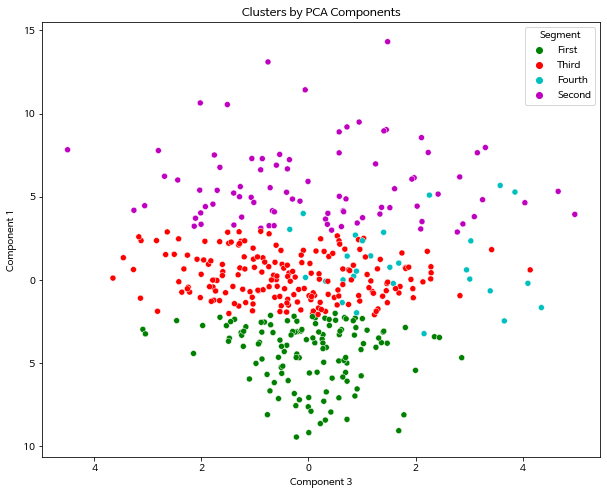

In [ ]:
x_axis = df_pca_kmeans['Component 3']
y_axis = df_pca_kmeans['Component 1']
plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis, y_axis, hue=df_pca_kmeans['Segment'], palette=['g', 'r', 'c', 'm'])
#sns.scatterplot(x_axis, y_axis, hue=df_pca_kmeans['Segment'])
plt.title('Clusters by PCA Components')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


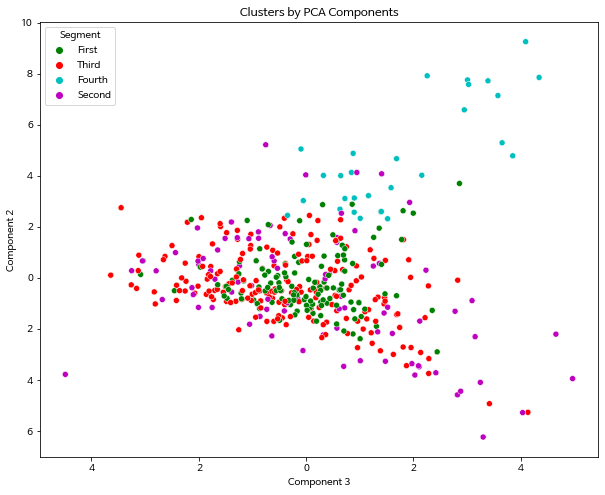

In [ ]:
x_axis = df_pca_kmeans['Component 3']
y_axis = df_pca_kmeans['Component 2']
plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis, y_axis, hue=df_pca_kmeans['Segment'], palette=['g', 'r', 'c', 'm'])
#sns.scatterplot(x_axis, y_axis, hue=df_pca_kmeans['Segment'])
plt.title('Clusters by PCA Components')
plt.show()

# Clustering Result Table

In [ ]:
# cluster 기준으로 데이터 세기
df_pca_kmeans.groupby('K-Means PCA 결과').count()

,평균나이,세대원1명,세대원2명,세대원3명이상,1인가구,2인가구,3인이상가구,외국인인구,비혈연6인이상가구인구,집단가구인구,...,면허소지자_50대,면허소지자_60대,면허소지자_70대,면허소지자_80대이상,등록된차량수,주차장보급율,Component 1,Component 2,Component 3,Segment
K-Means PCA 결과,,,,,,,,,,,,,,,,,,,,,
0,125,125,125,125,125,125,125,125,125,125,...,125,125,125,125,125,125,125,125,125,125
1,85,85,85,85,85,85,85,85,85,85,...,85,85,85,85,85,85,85,85,85,85
2,186,186,186,186,186,186,186,186,186,186,...,186,186,186,186,186,186,186,186,186,186
3,28,28,28,28,28,28,28,28,28,28,...,28,28,28,28,28,28,28,28,28,28


In [ ]:
df_pca_kmeans_1 = df_pca_kmeans.drop(['Segment'], axis=1)
df_pca_kmeans_numeric = df_pca_kmeans_1.astype(float)
print(df_pca_kmeans_numeric.dtypes)

In [ ]:
# 기본 데이터셋 요약
df_pca_kmeans_numeric.describe()

,평균나이,세대원1명,세대원2명,세대원3명이상,1인가구,2인가구,3인이상가구,외국인인구,비혈연6인이상가구인구,집단가구인구,...,면허소지자_50대,면허소지자_60대,면허소지자_70대,면허소지자_80대이상,등록된차량수,주차장보급율,Component 1,Component 2,Component 3,K-Means PCA 결과
count,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,...,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,4.240000e+02,4.240000e+02,424.000000
mean,44.160849,4566.983491,2319.474057,3612.231132,3279.955189,2438.438679,3673.535377,622.669811,31.714623,186.764151,...,350035.495283,282060.799528,92004.841981,16297.167453,7472.474057,138.036321,0.000000,-1.675808e-17,8.379042e-18,1.275943
std,3.157134,2758.861894,932.200439,1779.259601,2112.141662,955.401244,1720.935734,1207.781631,43.616166,371.516051,...,140630.447408,115745.759309,37978.508914,6883.197573,3663.399055,18.912760,3.958268,2.044049e+00,1.520011e+00,0.961080
min,35.200000,159.000000,74.000000,91.000000,302.000000,230.000000,100.000000,5.000000,0.000000,0.000000,...,27950.000000,21012.000000,5261.000000,962.000000,789.000000,111.300000,-9.455097,-6.244717e+00,-4.485875e+00,0.000000
25%,42.400000,2618.250000,1672.000000,2391.000000,1822.000000,1788.750000,2496.750000,128.000000,6.000000,0.000000,...,251187.500000,207786.000000,63967.750000,11230.750000,4939.500000,124.700000,-2.545553,-1.031488e+00,-1.016164e+00,0.000000
50%,44.100000,4081.500000,2281.500000,3397.000000,2899.500000,2422.000000,3486.000000,277.000000,19.000000,66.000000,...,343525.000000,274577.000000,88324.000000,15195.500000,6859.000000,131.600000,-0.215972,-3.498007e-01,-4.328460e-02,2.000000
75%,45.900000,5906.000000,2820.250000,4638.250000,4191.000000,2977.250000,4650.750000,573.000000,44.000000,208.250000,...,444362.500000,350605.000000,115750.750000,20281.500000,9041.500000,147.600000,2.347889,8.352359e-01,8.894331e-01,2.000000
max,79.700000,17842.000000,6456.000000,10484.000000,13435.000000,6761.000000,10541.000000,12308.000000,500.000000,4497.000000,...,841550.000000,682372.000000,215804.000000,39078.000000,25200.000000,191.400000,14.318802,9.248172e+00,4.966971e+00,3.000000


## 클러스터별 그룹화

In [ ]:
# 조건에 따른 그룹별 데이터프레임 제작
is_cluster01 = df_pca_kmeans_numeric['K-Means PCA 결과'] == 0
is_cluster02 = df_pca_kmeans_numeric['K-Means PCA 결과'] == 1
is_cluster03 = df_pca_kmeans_numeric['K-Means PCA 결과'] == 2
is_cluster04 = df_pca_kmeans_numeric['K-Means PCA 결과'] == 3

Cluster1 = df_pca_kmeans_numeric[is_cluster01]
Cluster2 = df_pca_kmeans_numeric[is_cluster02]
Cluster3 = df_pca_kmeans_numeric[is_cluster03]
Cluster4 = df_pca_kmeans_numeric[is_cluster04]

C1_trait = Cluster1.describe()
C2_trait = Cluster2.describe()
C3_trait = Cluster3.describe()
C4_trait = Cluster4.describe()

In [ ]:
# 클러스터별 특성 csv로 저장
with open('/content/drive/MyDrive/다함께차찾자/Cluster1-trait.csv', 'w') as f:
  C1_trait.to_csv(f)

with open('/content/drive/MyDrive/다함께차찾자/Cluster2-trait.csv', 'w') as f:
  C2_trait.to_csv(f)

with open('/content/drive/MyDrive/다함께차찾자/Cluster3-trait.csv', 'w') as f:
  C3_trait.to_csv(f)

with open('/content/drive/MyDrive/다함께차찾자/Cluster4-trait.csv', 'w') as f:
  C4_trait.to_csv(f)

In [ ]:
# 클러스터링 결과값 csv로 저장
with open('/content/drive/MyDrive/다함께차찾자/Cluster-result.csv', 'w') as f:
  df_pca_kmeans.to_csv(f)